# Preliminary Analysis of CoronaVirus Time Series Data
In this notebook we will conduct some preliminary analysis and forecasting on the Coronavirus time seires data. For this analysis we will look at 

**Warning this is a basic analysis/machine learning model. The goal of this notebook is to gage the utility of data augmentation/transfer learning for virus forecasting. NOT provide actionable insights. It would additional rounds of training/validation + verification by epidemiologists and public health experts before I would be confident relying on using it for any actionable insights**

In [0]:
#!git clone https://github.com/CoronaWhy/task-geo.git
#os.chdir('task-geo')
#make install
import pandas as pd
!wget -O coronavirus_timeseries.csv https://coronadatascraper.com/timeseries.csv
!pip install wandb
!wandb login
import wandb
from tensorflow import keras
from wandb.keras import WandbCallback 

--2020-04-26 15:10:23--  https://coronadatascraper.com/timeseries.csv
Resolving coronadatascraper.com (coronadatascraper.com)... 185.199.110.153, 185.199.111.153, 185.199.108.153
Connecting to coronadatascraper.com (coronadatascraper.com)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34699757 (33M) [text/csv]
Saving to: ‘coronavirus_timeseries.csv’

coronavirus_timeser 100%[===================>]  33.09M  42.3MB/s    in 0.8s    

2020-04-26 15:10:23 (42.3 MB/s) - ‘coronavirus_timeseries.csv’ saved [34699757/34699757]

     |████████████████████████████████| 1.4MB 2.7MB/s 
     |████████████████████████████████| 112kB 20.5MB/s 
     |████████████████████████████████| 102kB 7.0MB/s 
     |████████████████████████████████| 102kB 8.6MB/s 
     |████████████████████████████████| 460kB 16.3MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
  Created wheel for gql: filename=gql-0.2.0-cp36

In [0]:
df = pd.read_csv("coronavirus_timeseries.csv")


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
unqiue_counties = df['county'].unique()
print(len(unqiue_counties))

2013


## Forecasting in Antwerp

In [0]:
antwerp_df = df[df['county']=='Antwerp'].fillna(0)
antwerp_relevant = antwerp_df[['cases', 'deaths', 'recovered', 'population', 'lat', 'long']].values
#antwerp_df.tail()
print(len(antwerp_df))

95


## Data Augmentation
We will now explore using the tsaug library for forecasting.. 

In [0]:
!pip install tsaug

In [0]:
from tsaug.visualization import plot 
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
my_augmenter = (TimeWarp() * 5, # random time warping 5 times in parallel 
                Crop(size=300),  # random crop subsequences with length 300
                Quantize(n_levels=[10, 20, 30]),  # random quantize to 10-, 20-, or 30- level sets
                Drift(max_drift=(0.1, 0.5)),   # with 80% probability, random drift the signal up to 10% - 50%
                Reverse()) #0.5  # with 50% probability, reverse the sequence)

In [0]:
#X_aug = my_augmenter[0].augment(antwerp_relevant)
print(antwerp_relevant.shape)
X_aug = TimeWarp(antwerp[:70])

## Models and Forecasting
We will now define some simple models in Keras for forecasting.

In [0]:
import numpy as np
from sklearn.preprocessing import RobustScaler
scaler_dict = {}
config_default = {"epochs":30, "validation_split":0.1, 
          "loss":"mean_squared_error", "optimizer":'adam', 
          "geo_segment":"antwerp", "seq_len":7, "train_steps":70, 
          "test_steps":27, "scaler":"RobustScaler", 
          "beta":0.899}
r = RobustScaler()
x_train_full = antwerp_df[['deaths', 'cases']][:config_default["train_steps"]]
x_train_full = pd.DataFrame(r.fit_transform(x_train_full))
y_train_full = x_train_full
r_test = RobustScaler()
test_orig = antwerp_df[['deaths', 'cases']][70:]
test = pd.DataFrame(r_test.fit_transform(test_orig))

In [0]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train, Y_train = create_dataset(x_train_full, y_train_full, config_default["seq_len"])
X_test, y_test = create_dataset(test, test, config_default["seq_len"])

In [0]:
sweep_config = {
  "name": "Default sweep",
  "method": "grid",
  "parameters": {
        "batch_size": {
            "values": [2, 3, 4, 5]
        },
        "learn":{
            "values":[0.001, 0.0015, 0.002, 0.003, 0.004, 0.01]
        } 
    }
}
sweep_id = wandb.sweep(sweep_config)

Create sweep with ID: sz2r7l4w
Sweep URL: https://app.wandb.ai/igodfried/uncategorized/sweeps/sz2r7l4w


In [0]:
def train():
  run = wandb.init(project="covid-forecast", config=config_default, magic=True)
  config = wandb.config
  opt = keras.optimizers.Adam(learning_rate=config["learn"], beta_1=config["beta"], beta_2=0.999, amsgrad=False)
  model = keras.Sequential()
  model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
        units=128,
        input_shape=(X_train.shape[1], X_train.shape[2])
      )
    )
  ) 
  model.add(keras.layers.Dropout(rate=0.2))
  model.add(keras.layers.Dense(units=2))
  model.compile(loss=config["loss"], optimizer=opt)

  history = model.fit(
      X_train, Y_train,
      epochs=config["epochs"],
      batch_size=config["batch_size"],
      validation_split=config["validation_split"],
      callbacks=[WandbCallback()],
      shuffle=False
  )
  evaluate_single(model, X_test, y_test, r)
  evaluate_plot_multi(model, test, config, X_test, r_test)
  return model

def evaluate_single(model, x_test, y_test, scaler):
  y_preds = model.predict(x_test)
  y_preds = scaler.inverse_transform(y_preds)
  y_test = scaler.inverse_transform(y_test)
  complete_mse = tf.keras.losses.MSE( y_preds[:, 1], y_test[:, 1])
  wandb.run.summary["test_mse"] = complete_mse
  return complete_mse

def evaluate_plot_multi(model, test_df, config, x_test, scaler):
  arr = predict_multi(model, len(test)-config["seq_len"], x_test[0, :, :])
  test_orig['predicted_cases'] = 0
  test_orig['predicted_cases'][config["seq_len"]:] = scaler.inverse_transform(arr.squeeze(0))[:, 1]
  plt.plot(test_orig['predicted_cases'], label='predicted_cases')
  plt.plot(test_orig['cases'], label='actual_cases')
  plt.legend();
  wandb.log({"test":plt})
  large_mse = tf.keras.losses.MSE(
    y_multi[:, 1], test_orig['predicted_cases'][config["seq_len"]:].values
  )
  wandb.run.summary["test_mse_full"] =  large_mse
  return large_mse


In [0]:
wandb.agent(sweep_id, function=train)
#train()

wandb: Agent Starting Run: zf1811zd with config:
	batch_size: 2
	learn: 0.004
wandb: Agent Started Run: zf1811zd


wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep
wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

28/28 [==============================] - 1s 33ms/step - loss: 0.0335 - val_loss: 4.7072
Epoch 2/30
28/28 [==============================] - 0s 9ms/step - loss: 0.1379 - val_loss: 2.1729
Epoch 3/30
28/28 [==============================] - 0s 8ms/step - loss: 0.0574 - val_loss: 7.6313
Epoch 4/30
28/28 [==============================] - 0s 8ms/step - loss: 0.1322 - val_loss: 3.6609
Epoch 5/30
28/28 [==============================] - 0s 8ms/step - loss: 0.0531 - val_loss: 4.7727
Epoch 6/30
28/28 

wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep
wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

28/28 [==============================] - 1s 35ms/step - loss: 0.0371 - val_loss: 1.4206
Epoch 2/30
28/28 [==============================] - 0s 9ms/step - loss: 0.1506 - val_loss: 6.6646
Epoch 3/30
28/28 [==============================] - 0s 9ms/step - loss: 0.2674 - val_loss: 5.6824
Epoch 4/30
28/28 [==============================] - 0s 8ms/step - loss: 0.7094 - val_loss: 9.4924
Epoch 5/30
28/28 [==============================] - 0s 8ms/step - loss: 0.2113 - val_loss: 4.3793
Epoch 6/30
28/28 

wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep
wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

19/19 [==============================] - 1s 48ms/step - loss: 0.7153 - val_loss: 27.9806
Epoch 2/30
19/19 [==============================] - 0s 11ms/step - loss: 0.0659 - val_loss: 7.0848
Epoch 3/30
19/19 [==============================] - 0s 11ms/step - loss: 0.1353 - val_loss: 2.2106
Epoch 4/30
19/19 [==============================] - 0s 10ms/step - loss: 0.2967 - val_loss: 12.8101
Epoch 5/30
19/19 [==============================] - 0s 10ms/step - loss: 0.0175 - val_loss: 5.4108
Epoch 6/30


wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep
wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

19/19 [==============================] - 1s 48ms/step - loss: 0.5047 - val_loss: 21.8142
Epoch 2/30
19/19 [==============================] - 0s 11ms/step - loss: 0.0563 - val_loss: 4.0202
Epoch 3/30
19/19 [==============================] - 0s 10ms/step - loss: 0.1321 - val_loss: 7.5540
Epoch 4/30
19/19 [==============================] - 0s 11ms/step - loss: 0.1917 - val_loss: 3.5322
Epoch 5/30
19/19 [==============================] - 0s 10ms/step - loss: 0.3889 - val_loss: 18.6477
Epoch 6/30


wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep
wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

19/19 [==============================] - 1s 47ms/step - loss: 0.3354 - val_loss: 12.7544
Epoch 2/30
19/19 [==============================] - 0s 10ms/step - loss: 0.1879 - val_loss: 2.2984
Epoch 3/30
19/19 [==============================] - 0s 10ms/step - loss: 0.8728 - val_loss: 30.8242
Epoch 4/30
19/19 [==============================] - 0s 9ms/step - loss: 0.2668 - val_loss: 15.4696
Epoch 5/30
19/19 [==============================] - 0s 10ms/step - loss: 0.0575 - val_loss: 5.9968
Epoch 6/30


wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep
wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

19/19 [==============================] - 1s 48ms/step - loss: 0.1364 - val_loss: 3.9718
Epoch 2/30
19/19 [==============================] - 0s 11ms/step - loss: 0.4265 - val_loss: 2.6598
Epoch 3/30
19/19 [==============================] - 0s 10ms/step - loss: 0.9670 - val_loss: 20.4074
Epoch 4/30
19/19 [==============================] - 0s 9ms/step - loss: 0.0372 - val_loss: 6.7785
Epoch 5/30
19/19 [==============================] - 0s 11ms/step - loss: 0.1639 - val_loss: 6.4864
Epoch 6/30
19

wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep
wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

19/19 [==============================] - 1s 48ms/step - loss: 0.0549 - val_loss: 5.8718
Epoch 2/30
19/19 [==============================] - 0s 10ms/step - loss: 0.0753 - val_loss: 2.2201
Epoch 3/30
19/19 [==============================] - 0s 11ms/step - loss: 0.1377 - val_loss: 1.8927
Epoch 4/30
19/19 [==============================] - 0s 10ms/step - loss: 0.5797 - val_loss: 14.4009
Epoch 5/30
19/19 [==============================] - 0s 10ms/step - loss: 0.1509 - val_loss: 5.9510
Epoch 6/30
1

wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep
wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

19/19 [==============================] - 1s 47ms/step - loss: 0.1316 - val_loss: 5.6258
Epoch 2/30
19/19 [==============================] - 0s 11ms/step - loss: 0.2179 - val_loss: 1.7402
Epoch 3/30
19/19 [==============================] - 0s 10ms/step - loss: 0.0496 - val_loss: 3.1510
Epoch 4/30
19/19 [==============================] - 0s 10ms/step - loss: 0.1826 - val_loss: 5.3884
Epoch 5/30
19/19 [==============================] - 0s 9ms/step - loss: 0.3395 - val_loss: 5.5990
Epoch 6/30
19/

wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep
wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 64ms/step - loss: 0.6340 - val_loss: 29.7070
Epoch 2/30
14/14 [==============================] - 0s 11ms/step - loss: 0.1834 - val_loss: 12.5767
Epoch 3/30
14/14 [==============================] - 0s 12ms/step - loss: 0.0300 - val_loss: 3.3162
Epoch 4/30
14/14 [==============================] - 0s 14ms/step - loss: 0.0324 - val_loss: 2.9804
Epoch 5/30
14/14 [==============================] - 0s 10ms/step - loss: 0.0408 - val_loss: 3.7650
Epoch 6/30


wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep
wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 65ms/step - loss: 0.6301 - val_loss: 28.9900
Epoch 2/30
14/14 [==============================] - 0s 11ms/step - loss: 0.0673 - val_loss: 7.2441
Epoch 3/30
14/14 [==============================] - 0s 13ms/step - loss: 0.1796 - val_loss: 1.4784
Epoch 4/30
14/14 [==============================] - 0s 10ms/step - loss: 0.2351 - val_loss: 13.4121
Epoch 5/30
14/14 [==============================] - 0s 9ms/step - loss: 0.1001 - val_loss: 9.2243
Epoch 6/30
1

wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep
wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 63ms/step - loss: 0.5238 - val_loss: 23.0237
Epoch 2/30
14/14 [==============================] - 0s 11ms/step - loss: 0.0272 - val_loss: 2.6523
Epoch 3/30
14/14 [==============================] - 0s 9ms/step - loss: 0.0347 - val_loss: 2.7267
Epoch 4/30
14/14 [==============================] - 0s 12ms/step - loss: 0.1298 - val_loss: 3.8921
Epoch 5/30
14/14 [==============================] - 0s 10ms/step - loss: 0.2060 - val_loss: 10.2127
Epoch 6/30
1

wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep
wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 63ms/step - loss: 0.3224 - val_loss: 13.2952
Epoch 2/30
14/14 [==============================] - 0s 11ms/step - loss: 0.2293 - val_loss: 2.3184
Epoch 3/30
14/14 [==============================] - 0s 11ms/step - loss: 0.8363 - val_loss: 34.2812
Epoch 4/30
14/14 [==============================] - 0s 9ms/step - loss: 0.4122 - val_loss: 21.9319
Epoch 5/30
14/14 [==============================] - 0s 9ms/step - loss: 0.1091 - val_loss: 9.2573
Epoch 6/30
1

wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep
wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 63ms/step - loss: 0.1585 - val_loss: 5.0318
Epoch 2/30
14/14 [==============================] - 0s 11ms/step - loss: 0.4696 - val_loss: 2.3291
Epoch 3/30
14/14 [==============================] - 0s 11ms/step - loss: 0.7984 - val_loss: 39.9806
Epoch 4/30
14/14 [==============================] - 0s 9ms/step - loss: 0.3939 - val_loss: 13.7674
Epoch 5/30
14/14 [==============================] - 0s 9ms/step - loss: 0.1354 - val_loss: 9.7261
Epoch 6/30
14

wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep
wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 62ms/step - loss: 0.0997 - val_loss: 0.8689
Epoch 2/30
14/14 [==============================] - 0s 11ms/step - loss: 0.3539 - val_loss: 0.7217
Epoch 3/30
14/14 [==============================] - 0s 10ms/step - loss: 0.8958 - val_loss: 4.4309
Epoch 4/30
14/14 [==============================] - 0s 10ms/step - loss: 0.5164 - val_loss: 23.3169
Epoch 5/30
14/14 [==============================] - 0s 9ms/step - loss: 1.4338 - val_loss: 20.6575
Epoch 6/30
1

wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep
wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 71ms/step - loss: 1.4021 - val_loss: 34.4464
Epoch 2/30
12/12 [==============================] - 0s 13ms/step - loss: 0.5742 - val_loss: 17.2435
Epoch 3/30
12/12 [==============================] - 0s 13ms/step - loss: 0.0680 - val_loss: 5.5815
Epoch 4/30
12/12 [==============================] - 0s 13ms/step - loss: 0.1382 - val_loss: 2.7532
Epoch 5/30
12/12 [==============================] - 0s 11ms/step - loss: 0.0726 - val_loss: 6.7478
Epoch 6/30


wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep
wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 71ms/step - loss: 1.0004 - val_loss: 25.6818
Epoch 2/30
12/12 [==============================] - 0s 13ms/step - loss: 0.0649 - val_loss: 5.3285
Epoch 3/30
12/12 [==============================] - 0s 13ms/step - loss: 0.3269 - val_loss: 1.3598
Epoch 4/30
12/12 [==============================] - 0s 11ms/step - loss: 0.3570 - val_loss: 11.6963
Epoch 5/30
12/12 [==============================] - 0s 10ms/step - loss: 0.1385 - val_loss: 7.3525
Epoch 6/30


wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep
wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 71ms/step - loss: 1.2642 - val_loss: 27.6543
Epoch 2/30
12/12 [==============================] - 0s 12ms/step - loss: 0.0301 - val_loss: 3.8069
Epoch 3/30
12/12 [==============================] - 0s 13ms/step - loss: 0.3067 - val_loss: 1.5160
Epoch 4/30
12/12 [==============================] - 0s 10ms/step - loss: 0.6050 - val_loss: 15.1500
Epoch 5/30
12/12 [==============================] - 0s 10ms/step - loss: 0.1719 - val_loss: 8.6171
Epoch 6/30


wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep
wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 71ms/step - loss: 0.8769 - val_loss: 18.7156
Epoch 2/30
12/12 [==============================] - 0s 13ms/step - loss: 0.2259 - val_loss: 3.5145
Epoch 3/30
12/12 [==============================] - 0s 11ms/step - loss: 1.0257 - val_loss: 22.8876
Epoch 4/30
12/12 [==============================] - 0s 10ms/step - loss: 0.2683 - val_loss: 12.8745
Epoch 5/30
12/12 [==============================] - 0s 11ms/step - loss: 0.0915 - val_loss: 6.6803
Epoch 6/30

wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep
wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 69ms/step - loss: 0.5793 - val_loss: 9.9515
Epoch 2/30
12/12 [==============================] - 0s 13ms/step - loss: 0.8077 - val_loss: 4.3509
Epoch 3/30
12/12 [==============================] - 0s 11ms/step - loss: 1.9880 - val_loss: 43.2244
Epoch 4/30
12/12 [==============================] - 0s 10ms/step - loss: 1.0050 - val_loss: 27.0267
Epoch 5/30
12/12 [==============================] - 0s 11ms/step - loss: 0.3387 - val_loss: 12.8716
Epoch 6/30

wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep
wandb: WARNING Ignoring project='covid-forecast' passed to wandb.init when running a sweep


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 71ms/step - loss: 0.3085 - val_loss: 14.7724
Epoch 2/30
12/12 [==============================] - 0s 12ms/step - loss: 0.4912 - val_loss: 11.7874
Epoch 3/30
12/12 [==============================] - 0s 12ms/step - loss: 1.7113 - val_loss: 17.2346
Epoch 4/30
12/12 [==============================] - 0s 11ms/step - loss: 1.6644 - val_loss: 42.6668
Epoch 5/30
12/12 [==============================] - 0s 13ms/step - loss: 0.3710 - val_loss: 10.3652
Epoch 6/

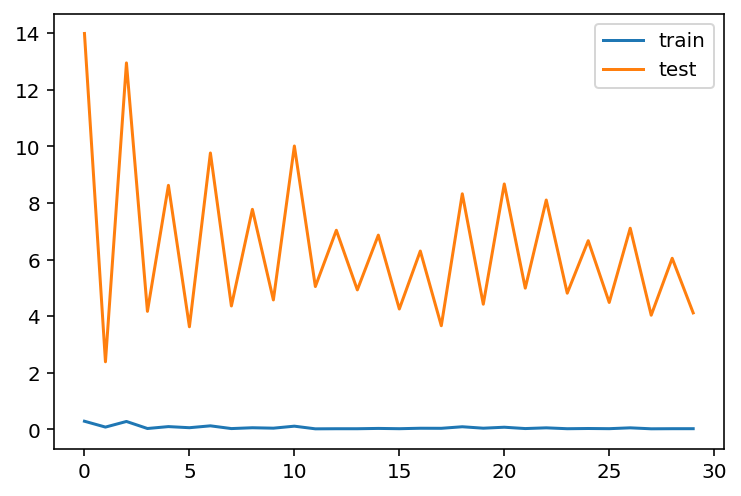

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

### Examining Results
We will now predict both one step ahead and 20 steps ahead.

In [0]:
res = model.predict(X_test)
res = r_test.inverse_transform(res)
res

array([[-2.1279370e-02,  2.0092883e+03],
       [-1.8879963e-02,  2.2472920e+03],
       [-1.6375745e-02,  2.5275439e+03],
       [-1.3892809e-02,  2.8506108e+03],
       [-1.1596879e-02,  3.1829221e+03],
       [-9.0861954e-03,  3.5029392e+03],
       [-6.4477865e-03,  3.7825161e+03],
       [-3.6051013e-03,  4.0421055e+03],
       [-1.2287628e-03,  4.2927124e+03],
       [ 3.3153594e-04,  4.5448154e+03],
       [ 1.1798348e-03,  4.7915127e+03],
       [ 2.0689592e-03,  5.0360225e+03],
       [ 3.3188127e-03,  5.2662153e+03],
       [ 5.0343592e-03,  5.5053794e+03],
       [ 6.5031778e-03,  5.7533242e+03],
       [ 7.2021466e-03,  5.9751943e+03],
       [ 7.6369299e-03,  6.1531494e+03]], dtype=float32)

In [0]:
y_true = r_test.inverse_transform(y_test)
y_true

array([[   0., 3521.],
       [   0., 3822.],
       [   0., 4086.],
       [   0., 4179.],
       [   0., 4265.],
       [   0., 4330.],
       [   0., 4470.],
       [   0., 4645.],
       [   0., 4855.],
       [   0., 4965.],
       [   0., 5028.],
       [   0., 5079.],
       [   0., 5241.],
       [   0., 5415.],
       [   0., 5449.],
       [   0., 5449.],
       [   0., 5449.]])

In [0]:
def predict_multi(model, time_steps, start_rows):
  start_rows=np.expand_dims(start_rows, axis=0)
  for i in range(0, time_steps):
    out = model.predict(start_rows[:, i:, :])
    out = out[np.newaxis, ...]
    start_rows = np.concatenate((start_rows, out), axis=1)
  return start_rows[:, config["seq_len"]:, :]

arr = predict_multi(model, len(test)-config["seq_len"], X_test[0, :, :])
test_orig['predicted_cases'] = 0
test_orig['predicted_cases'][config["seq_len"]:] = r_test.inverse_transform(arr.squeeze(0))[:, 1]
plt.plot(test_orig['predicted_cases'], label='predicted_cases')
plt.plot(test_orig['cases'], label='actual_cases')
plt.legend();
wandb.log({"test":plt})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [0]:
r_test.inverse_transform(X_test[0, :, :])

array([[   0., 2342.],
       [   0., 2508.],
       [   0., 2694.],
       [   0., 2802.],
       [   0., 2881.],
       [   0., 3128.],
       [   0., 3307.]])

In [0]:
y_multi = r_test.inverse_transform(arr.squeeze(0))
y_multi

array([[-2.12793704e-02,  2.00928912e+03],
       [-2.36456450e-02,  1.96579090e+03],
       [-2.32349541e-02,  1.79785547e+03],
       [-2.29426380e-02,  1.55205121e+03],
       [-2.49109063e-02,  1.25682677e+03],
       [-3.02774105e-02,  9.26331511e+02],
       [-3.81791964e-02,  5.71013687e+02],
       [-4.35400605e-02,  2.24849555e+02],
       [-4.84175906e-02, -5.02670822e+01],
       [-5.37138134e-02, -3.33807449e+02],
       [-5.92226684e-02, -6.05690453e+02],
       [-6.46216497e-02, -8.56124453e+02],
       [-6.95688501e-02, -1.08077419e+03],
       [-7.38583505e-02, -1.27827176e+03],
       [-7.75195137e-02, -1.44942704e+03],
       [-8.07663053e-02, -1.59675538e+03],
       [-8.34889859e-02, -1.72313082e+03]])

In [0]:
import tensorflow as tf
x_test = y_true[:, 1] 
wandb.run.summary["test_mse"] = tf.keras.losses.MSE(
    x_test, res[:, 1]
)

In [0]:
wandb.run.summary["test_mse_full"] = tf.keras.losses.MSE(
    y_multi[:, 1], x_test
)

### PyTorch models


In [0]:
import torch
import math
from torch.nn.modules import Transformer, TransformerEncoder, TransformerDecoder, TransformerDecoderLayer, TransformerEncoderLayer, LayerNorm
class CustomTransformerDecoder(torch.nn.Module):
    def __init__(self, seq_length, output_seq_length, n_time_series, d_model=128, output_dim=1):
        super().__init__()
        self.dense_shape = torch.nn.Linear(n_time_series, d_model)
        self.pe = SimplePositionalEncoding(d_model)
        encoder_layer = TransformerEncoderLayer(d_model, 8)
        encoder_norm = LayerNorm(d_model)
        self.transformer_enc = TransformerEncoder(encoder_layer, 6, encoder_norm)
        self.output_dim_layer = torch.nn.Linear(d_model, output_dim)
        self.output_seq_length = output_seq_length
        self.out_length_lay  = torch.nn.Linear(seq_length, output_seq_length)
        self.mask = generate_square_subsequent_mask(seq_length)
    def forward(self, x):
        """"""
        x = self.dense_shape(x)
        x = self.pe(x)
        x = x.permute(1,0,2)
        x = self.transformer_enc(x, mask=self.mask)
        x = self.output_dim_layer(x)
        x = x.permute(1, 2, 0)
        x = self.out_length_lay(x)
        return x.view(-1, self.output_seq_length)
    
class SimplePositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(SimplePositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x:torch.Tensor)->torch.Tensor:
        """Creates a basic positional encoding"""
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
        
def generate_square_subsequent_mask(sz:int)->torch.Tensor:
        r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [0]:
c = CustomTransformerDecoder(50, 1, 3)

In [0]:
c(torch.rand(2, 50, 3))

tensor([[-0.2974],
        [-0.2575]], grad_fn=<ViewBackward>)

In [0]:
class LSTMForecast(torch.nn.Module):
  def __init__(self, seq_length: int, n_time_series: int, output_seq_len=1, hidden_states=20, num_layers=2, bias=True):
    super().__init__()
    self.num_layers = num_layers
    self.forecast_history = seq_length
    self.n_time_series = n_time_series
    self.hidden_dim = hidden_states
    self.lstm = torch.nn.LSTM(n_time_series, hidden_states, num_layers, bias, batch_first=True)
    self.final_layer = torch.nn.Linear(seq_length*hidden_states, output_seq_len)

  def init_hidden(self, batch_size):
    # even with batch_first = True this remains same as docs
    hidden_state = torch.zeros(self.num_layers,batch_size,self.hidden_dim)
    cell_state = torch.zeros(self.num_layers,batch_size,self.hidden_dim)
    self.hidden = (hidden_state, cell_state)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    print(x.size()[0])
    batch_size = x.size()[0]
    out_x,self.hidden = self.lstm(x, self.hidden)
    x = self.final_layer(out_x.contiguous().view(batch_size, -1))
    return x